# Natural Language Processing with Disaster Tweets
This notebook is a submission for the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview) competition. The goal is to build a model that accurately classifies when tweets are about real disasters or not. The notebook is broken down into the following sections:
- EDA
- Preprocessing
- Model Architecture
- Results & Analysis
- Test Model
- Conclusion

The models were all constructed using [Keras](https://keras.io/guides/)

## Load Data

In [1]:
# !kaggle competitions download -c nlp-getting-started

In [2]:
# import zipfile

# zip_path = 'nlp-getting-started.zip'
# extract_path = './data'

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

## Imports

In [1]:
import re 
import nltk
import tensorflow as tf
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Dropout, Input, MaxPooling1D, GlobalMaxPooling1D, LSTM, Embedding, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy


from keras_self_attention import SeqSelfAttention

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# EDA

EDA Section

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [5]:
train.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [6]:
test.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [9]:
train.shape, test.shape

((7613, 5), (3263, 4))

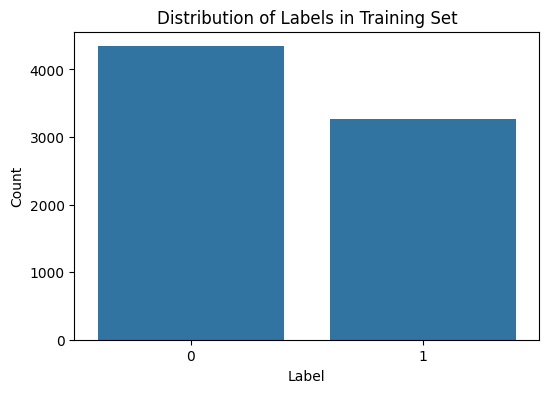

In [10]:
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=train)
plt.title('Distribution of Labels in Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# Preprocessing

In [11]:
train.drop(['keyword', 'location'], axis=1, inplace=True)
train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
def preprocess(text):
    """
    Preprocesses the text data by removing HTML tags, 
    URLs, special characters, converting to lowercase, 
    tokenizing, removing stopwords, and stemming.

    Args:
        text (string): _description_

    Returns:
        preprocessed_text (LiteralString): _description_
    """
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    
    tokens = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [13]:
train['text'] = train['text'].apply(preprocess)

In [14]:
train.head()

,id,text,target
0,1,deed reason earthquak may allah forgiv us,1
1,4,forest fire near la rong sask canada,1
2,5,resid ask shelter place notifi offic evacu she...,1
3,6,peopl receiv wildfir evacu order california,1
4,7,got sent photo rubi alaska smoke wildfir pour ...,1


In [15]:
X = train["text"]
Y = train['target'].values

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [17]:
X_test = test["text"]

In [18]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [19]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

Found 11955 unique tokens.


In [20]:
data_train = pad_sequences(sequences_train)
print(f'Shape of data train tensor: {data_train.shape}')

Shape of data train tensor: (6090, 23)


In [21]:
T = data_train.shape[1]

In [22]:
data_val = pad_sequences(sequences_val, maxlen=T)
print(f'Shape of data test tensor: {data_val.shape}')

Shape of data test tensor: (1523, 23)


# Model Architecture
I will be constructing 3 model architectures. I will add more layers to each one after I assess the performance of the model before.

## Hyperparameters

`D` and `M` are hyperparameters in the context of Natural Language Processing (NLP) and specifically when dealing with embeddings and recurrent neural networks (RNNs).

- `D` (Embedding Dimensionality): This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. It is the size of the dense vector that will represent each word. Higher values allow the model to capture more complex representations but also increase computational cost.

- `M` (Hidden State Dimensionality): This refers to the number of units in a hidden layer of an RNN. A higher number means the model has more capacity to learn from the data, at the cost of increased computational complexity. This is the size of the "memory" that the RNN layer has. It's the amount of information it can carry from one timestep to the next.

After playing around with different values, I found that having a size of 100 for `D` and a size 90 for `M` was the most optimal, as the performance was not enhanced any further with the added complexities.

The number of epochs was chosen as 50 since 10 didn't seem to capture enough features and 100 saw a lot of overfitting and early stopping. 

In [23]:
D = 100
M = 90
epochs = 50

## Helpers
These functions are to create visualizations so that we can see the performance of the model better.

In [24]:
def ConfusionMatrix(y_true, y_pred, dataset): 
    """Creates a confusion matrix and calculates the F1 score.

    Args:
        y_true (ndarry): True labels
        y_pred (ndarry): Predicted labels
        dataset (ndarry): Name of the dataset
    """
    y_pred = np.transpose(y_pred)[0]
    binary_predictions = (y_pred >= 0.5).astype(int).flatten()
    
    display = ConfusionMatrixDisplay.from_predictions(
        y_true,
        binary_predictions,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    f1 = f1_score(y_true, binary_predictions, average='weighted')

    display.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1.round(2)))

In [25]:
def PlotMetric(history, metric: str):
    """Plots the metric for the training and validation sets.

    Args:
        history (History): History object from the model
        metric (str): Metric to plot
    """
    plt.plot(history.history[metric], label=metric.capitalize())
    plt.plot(history.history[f'val_{metric}'], label=f'val_{metric}'.capitalize())
    plt.title(str(metric).capitalize())
    plt.xlabel('Epoch')
    plt.ylabel(str(metric).capitalize())
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.legend()

## Model 1
**Input Layer**
- `Input(shape=(T,))`: Input layer with shape `(T,)`, where `T` is the length of the input sequences

**Embedding Layer**
- `Embedding(V + 1, D)`: Embedding layer with `V + 1` vocabulary size and `D` embedding dimensions. 

**Recurrent Layer**
- `LSTM(M, return_sequences=True)`:
    - LSTM layer with `M` units.
    - Returns the full sequence of outputs for each input sequence.

**Pooling Layer**
- `GlobalMaxPooling1D()`:
    - Global max pooling layer to reduce the dimensionality of the input by taking the maximum value over time steps.

**Dropout Layer**
- `Dropout(0.5)`:
    - Dropout layer with a dropout rate of `0.5` for regularization to prevent overfitting.

**Output Layer**
- `Dense(1, activation='sigmoid')`:
  - Output layer with a single unit and sigmoid activation for binary classification.

In [26]:
m1 = Sequential([
    Input(shape=(T,)),
    Embedding(V + 1, D),
    LSTM(M, return_sequences=True),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name='model_1')

2024-06-19 21:48:04.734145: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-06-19 21:48:04.734164: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-06-19 21:48:04.734168: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-06-19 21:48:04.734185: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-19 21:48:04.734196: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [27]:
m1.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

m1.summary()

Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 23, 100)        │     1,195,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 23, 90)         │        68,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 90)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            91 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,451 (4.82 MB)

 Trainable params: 1,264,451 (4.82 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = m1.fit(
    data_train,
    y_train,
    epochs=epochs,
    batch_size=96,
    validation_data=(data_val, y_val)
)

Epoch 1/50


2024-06-19 21:48:30.548916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5681 - loss: 0.6783 - val_accuracy: 0.7288 - val_loss: 0.5445
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8175 - loss: 0.4291 - val_accuracy: 0.8050 - val_loss: 0.4445
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9072 - loss: 0.2672 - val_accuracy: 0.7932 - val_loss: 0.5022
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9425 - loss: 0.1735 - val_accuracy: 0.7800 - val_loss: 0.5791
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9653 - loss: 0.1180 - val_accuracy: 0.7557 - val_loss: 0.6921
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9702 - loss: 0.1000 - val_accuracy: 0.7820 - val_loss: 0.6781
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9790 - loss: 0.0743 - val_accuracy: 0.7728 - val_loss: 0.6982
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9806 - loss: 0.0670 - val_accuracy: 0.7735 - val_loss: 0.

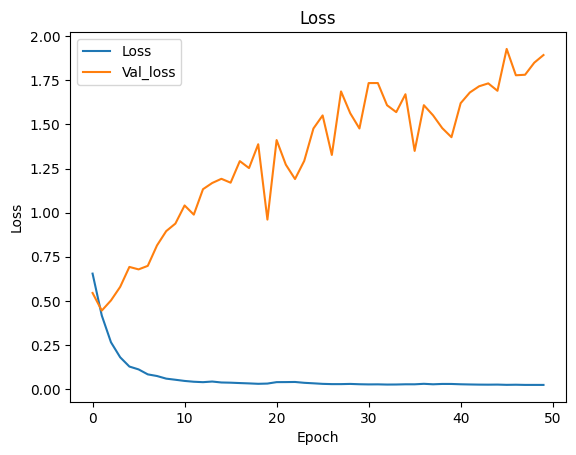

In [29]:
PlotMetric(history, 'loss')

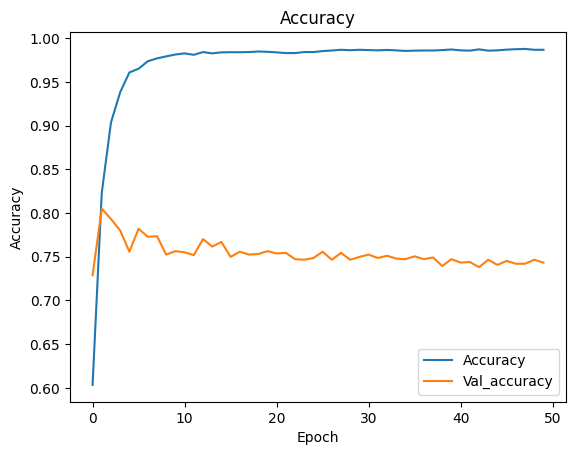

In [30]:
PlotMetric(history, 'accuracy')

In [31]:
y_pred = m1.predict(data_val)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


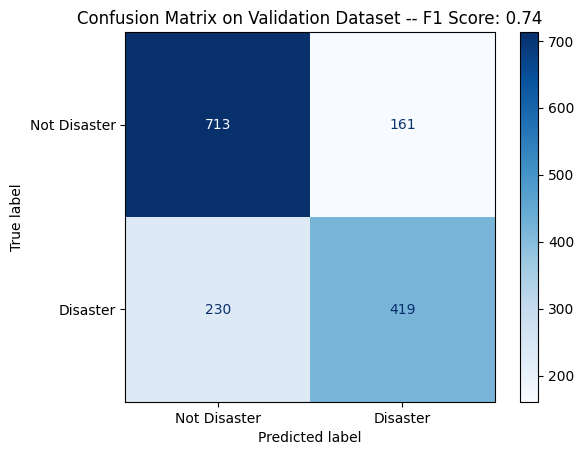

In [32]:
ConfusionMatrix(y_val, y_pred, "Validation")

## Model 2
Model 1 performed decent for a such a simple architecture. Model 2 will add some more layers. Here is the architecture:

**Input Layer**
- `Input(shape=(T,))`: Input layer with shape (T,), where T is the length of the input sequences.

**Embedding Layer**
- `Embedding(V + 1, D)`: Embedding layer with V + 1 vocabulary size and D embedding dimensions.

**Recurrent Layers**
1. `LSTM(M, return_sequences=True)`:
    - LSTM layer with M units.
    - Returns the full sequence of outputs for each input sequence.
    - Followed by a Batch Normalization layer to normalize activations.

2. `Bidirectional(LSTM(M, return_sequences=True))`:

    - Bidirectional LSTM layer with M units.
    - Returns the full sequence of outputs for each input sequence from both forward and backward passes.
    - Followed by a Batch Normalization layer to normalize activations.

3. `SeqSelfAttention`:

    - Attention mechanism with sigmoid activation.
    - Regularization:
        - `kernel_regularizer=l2(1e-2)`
        - `bias_regularizer=l2(1e-2)`
        - `attention_regularizer_weight=1e-2`
    - Name: `attention_1`
    - Followed by a Batch Normalization layer to normalize activations.

4. `Dropout(0.3)`:
    - Dropout layer with a dropout rate of 0.3 for regularization.

**Convolutional Layer**
- `Conv1D(128, 5, activation='relu', padding='same')`:
    - 1D convolutional layer with 128 filters, kernel size of 5, ReLU activation, and same padding.

**Pooling Layer**
- `GlobalMaxPooling1D()`:
    - Global max pooling layer to reduce the dimensionality of the input.

**Dense Layers**
1. `Dense(256, activation='relu', kernel_regularizer=l2(0.01))`:
    - Dense layer with 256 units and ReLU activation.
    - Regularization: `kernel_regularizer=l2(0.01)`.

2. `Dropout(0.5)`:
    - Dropout layer with a dropout rate of 0.5 for regularization.

**Output Layer**
- `Dense(1, activation='sigmoid')`:
  - Output layer with a single unit and sigmoid activation for binary classification.

In [33]:
m2 = Sequential([
    Input(shape=(T,)),
    Embedding(V + 1, D),
    
    # First LSTM Layer
    LSTM(M, return_sequences=True),
    BatchNormalization(),
    
    # Bidirectional LSTM Layer
    Bidirectional(LSTM(M, return_sequences=True)),
    BatchNormalization(),
    
    # Attention Layer
    SeqSelfAttention(attention_activation='sigmoid',
                     kernel_regularizer=l2(1e-2),
                     bias_regularizer=l2(1e-2),
                     attention_regularizer_weight=1e-2,
                     name='attention_1'),
    BatchNormalization(),
    Dropout(0.3),
    
    # Conv1D Layer
    Conv1D(128, 5, activation='relu', padding='same'),
    GlobalMaxPooling1D(),
    
    # Dense Layers with Dropout and Regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    
    # Output Layer
    Dense(1, activation='sigmoid')
], name='model_2')

In [34]:
m2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

m2.summary()

Model: "model_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 23, 100)        │     1,195,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 23, 90)         │        68,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 23, 90)         │           360 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 23, 180)        │       130,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 23, 180)        │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (SeqSelfAttention)  │ (None, 23, 180)        │        11,585 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 23, 180)        │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 23, 180)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 23, 128)        │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,556,674 (5.94 MB)

 Trainable params: 1,555,774 (5.93 MB)

 Non-trainable params: 900 (3.52 KB)

In [35]:
history = m2.fit(
    data_train,
    y_train,
    epochs=epochs,
    batch_size=96,
    validation_data=(data_val, y_val)
)

Epoch 1/50


64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 0.6005 - loss: 3.4346 - val_accuracy: 0.5739 - val_loss: 2.3056
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.8739 - loss: 1.7434 - val_accuracy: 0.5863 - val_loss: 1.6524
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.9334 - loss: 1.0644 - val_accuracy: 0.5857 - val_loss: 1.3361
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.9703 - loss: 0.7183 - val_accuracy: 0.6297 - val_loss: 1.1254
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.9699 - loss: 0.5531 - val_accuracy: 0.7393 - val_loss: 0.9712
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.9787 - loss: 0.4479 - val_accuracy: 0.7183 - val_loss: 0.8830
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9814 - loss: 0.3756 - val_accuracy: 0.7420 - val_loss: 0.8319
Epoch 8/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.9783 - loss: 0.3424 - val_accuracy: 0.732

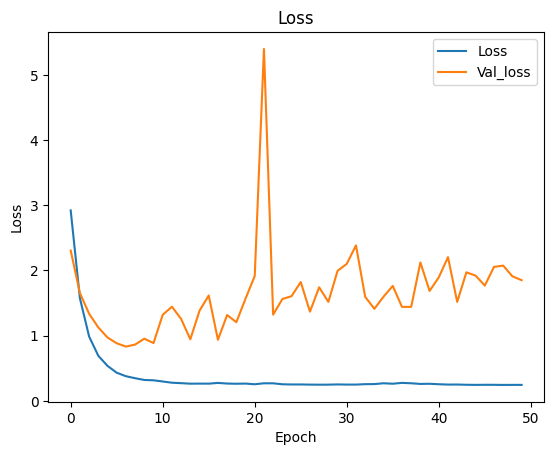

In [36]:
PlotMetric(history, 'loss')

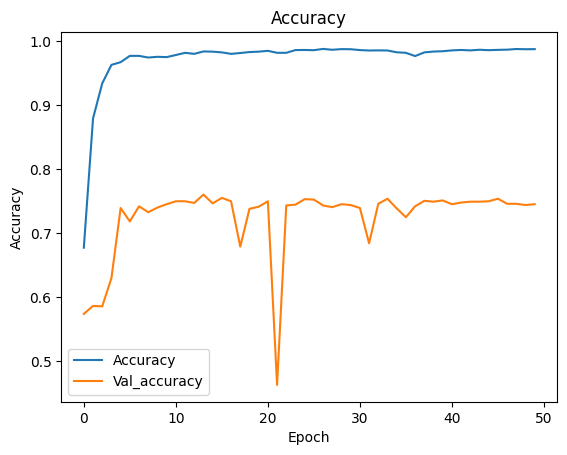

In [37]:
PlotMetric(history, 'accuracy')

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step


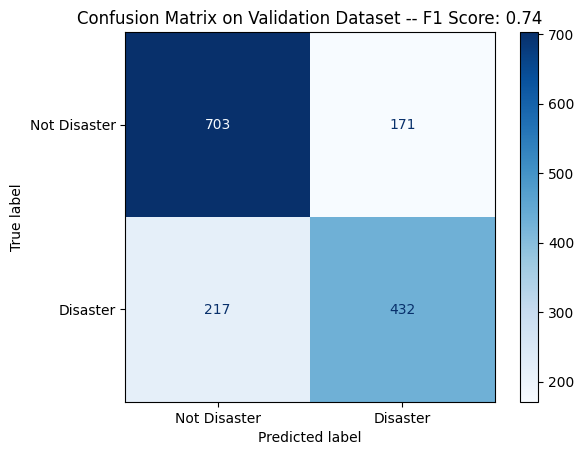

In [38]:
y_pred = m2.predict(data_val)

ConfusionMatrix(y_val, y_pred, "Validation")

## Model 3
**Input Layer**
- `Input(shape=(T,))`: Input layer with shape `(T,)`, where `T` is the length of the input sequences.

**Embedding Layer**
- `Embedding(V + 1, D)`: Embedding layer with `V + 1` vocabulary size and `D` embedding dimensions.

**Recurrent Layers**
1. `LSTM(M, return_sequences=True)`: 
   - LSTM layer with `M` units.
   - Returns the full sequence of outputs for each input sequence.

2. `Bidirectional(LSTM(M, return_sequences=True))`:
   - Bidirectional LSTM layer with `M` units.
   - Returns the full sequence of outputs for each input sequence from both forward and backward passes.

3. `SeqSelfAttention`:
   - Attention mechanism using multiplicative attention.
   - Regularization: 
     - `kernel_regularizer=l2(1e-2)`
     - `bias_regularizer=l1(1e-2)`
     - `attention_regularizer_weight=1e-2`
   - Name: `attention_1`

4. `BatchNormalization`:
   - Batch normalization layer to normalize activations.

5. `Dropout(0.3)`:
   - Dropout layer with a dropout rate of 0.3 for regularization.

6. `LSTM(M, return_sequences=True)`:
   - LSTM layer with `M` units.
   - Returns the full sequence of outputs for each input sequence.

7. `Bidirectional(LSTM(M, return_sequences=True))`:
   - Bidirectional LSTM layer with `M` units.
   - Returns the full sequence of outputs for each input sequence from both forward and backward passes.

8. `SeqSelfAttention`:
   - Attention mechanism using multiplicative attention.
   - Regularization: 
     - `kernel_regularizer=l2(1e-2)`
     - `bias_regularizer=l1(1e-2)`
     - `attention_regularizer_weight=1e-2`
   - Name: `attention_2`

9. `BatchNormalization`:
   - Batch normalization layer to normalize activations.

10. `Dropout(0.3)`:
    - Dropout layer with a dropout rate of 0.3 for regularization.

**Convolutional Layer**
- `Conv1D(64, 5, activation='relu', padding='same')`:
  - 1D convolutional layer with 64 filters, kernel size of 5, ReLU activation, and same padding.

**Pooling Layer**
- `GlobalMaxPooling1D()`:
  - Global max pooling layer to reduce the dimensionality of the input.

**Dense Layers**
1. `Dense(256, activation='relu', kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))`:
   - Dense layer with 256 units and ReLU activation.
   - Regularization: `kernel_regularizer=l2(0.01)`, `activity_regularizer=l2(0.01)`.

2. `Dropout(0.5)`:
   - Dropout layer with a dropout rate of 0.5 for regularization.

**Output Layer**
- `Dense(1, activation='sigmoid')`:
  - Output layer with a single unit and sigmoid activation for binary classification.


`ReduceLROnPlateau` reduces the learning rate when a metric has stopped improving. 

`EarlyStopping` automatically determines the optimal number of epochs.

In [39]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [40]:
m3 = Sequential([
    Input(shape=(T,)),
    Embedding(V + 1, D),
    
    # First LSTM Layer
    LSTM(M, return_sequences=True),
    
    # First Bidirectional LSTM Layer
    Bidirectional(LSTM(M, return_sequences=True)),
    
    # First Attention Layer
    SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=l2(1e-2),
                     bias_regularizer=l1(1e-2),
                     attention_regularizer_weight=1e-2,
                     name='attention_1'),
    BatchNormalization(),
    Dropout(0.3),  # Added dropout for regularization
    
    # Second LSTM Layer
    LSTM(M, return_sequences=True),
    
    # Second Bidirectional LSTM Layer
    Bidirectional(LSTM(M, return_sequences=True)),
    
    # Second Attention Layer
    SeqSelfAttention(attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL,
                     kernel_regularizer=l2(1e-2),
                     bias_regularizer=l1(1e-2),
                     attention_regularizer_weight=1e-2,
                     name='attention_2'),
    BatchNormalization(),
    Dropout(0.3),  # Added dropout for regularization
    
    # Convolutional Layer
    Conv1D(64, 5, activation='relu', padding='same'),  # Reduced number of filters
    GlobalMaxPooling1D(),
    
    # Dense Layers with Dropout and Regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01)),  # Reduced units in Dense layer
    Dropout(0.5),
    
    # Output Layer
    Dense(1, activation='sigmoid')
], name='m3')


In [41]:
m3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

m3.summary()

Model: "m3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 23, 100)        │     1,195,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 23, 90)         │        68,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 23, 180)        │       130,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_1 (SeqSelfAttention)  │ (None, 23, 180)        │        32,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 23, 180)        │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 23, 180)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 23, 90)         │        97,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 23, 180)        │       130,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_2 (SeqSelfAttention)  │ (None, 23, 180)        │        32,401 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 23, 180)        │           720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 180)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 23, 64)         │        57,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,763,363 (6.73 MB)

 Trainable params: 1,762,643 (6.72 MB)

 Non-trainable params: 720 (2.81 KB)

In [42]:
history = m3.fit(
    data_train,
    y_train,
    epochs=epochs,
    batch_size=96, 
    validation_data=(data_val, y_val),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50


64/64 ━━━━━━━━━━━━━━━━━━━━ 31s 409ms/step - accuracy: 0.4986 - loss: 15.2828 - val_accuracy: 0.5739 - val_loss: 2.7924 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.5681 - loss: 2.5337 - val_accuracy: 0.5739 - val_loss: 2.0164 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 369ms/step - accuracy: 0.5782 - loss: 1.9481 - val_accuracy: 0.5739 - val_loss: 1.7977 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 362ms/step - accuracy: 0.5662 - loss: 1.7741 - val_accuracy: 0.5739 - val_loss: 1.7057 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.5725 - loss: 1.6904 - val_accuracy: 0.5739 - val_loss: 1.6433 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 363ms/step - accuracy: 0.5695 - loss: 1.6313 - val_accuracy: 0.5739 - val_loss: 1.5916 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 370ms/step - accuracy: 0.5779 - loss: 1.5775 - val

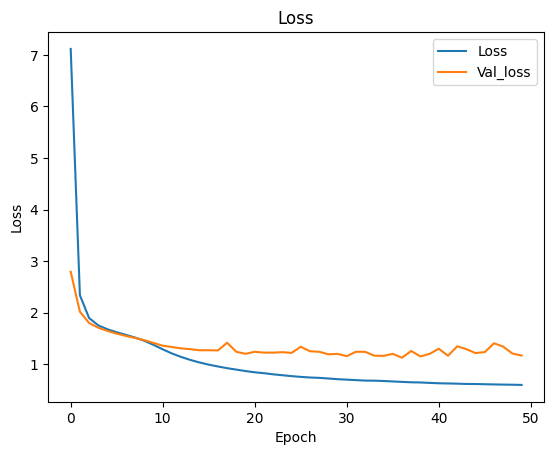

In [43]:
PlotMetric(history, 'loss')

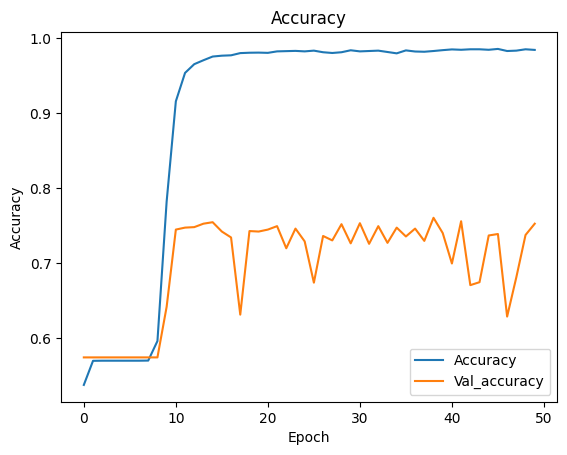

In [44]:
PlotMetric(history, 'accuracy')

48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step


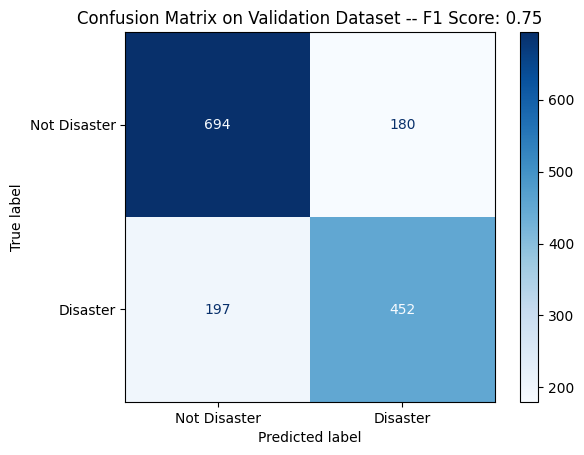

In [45]:
y_pred = m3.predict(data_val)

ConfusionMatrix(y_val, y_pred, "Validation")

# Results & Analysis
Here are the results of each model

`m1`:

F1 Score: 0.74

|  Metric  | Training |  Valid   |
| -------- | -------- | -------- |
| Accuracy | 0.9908   | 0.7866   |
| Loss     | 0.0472   | 0.7415   |

`m2`:

F1 Score: 0.74

|  Metric  | Training |  Valid   |
| -------- | -------- | -------- |
| Accuracy | 0.9882   | 0.7452   |
| Loss     | 0.2451   | 1.8508   |

`m3`:

F1 Score: 0.75

|  Metric  | Training |  Valid   |
| -------- | -------- | -------- |
| Accuracy | 0.9860   | 0.7525   |
| Loss     | 0.5940   | 1.1667   |

Although I changed the architecture significantly for each model, the results were very similar. I decided to use M3 for the test data since the F1 score was higher than the others. The accuracy for each epoch were so similar that I didn't feel it made much of a difference and that the F1 would help more.

# Test Model
Creating a submission with `m3`

In [46]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_test)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [47]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f'Found {V} unique tokens.')

data_test = pad_sequences(sequences_test)
print(f'Shape of data train tensor: {data_test.shape}')

Found 12818 unique tokens.
Shape of data train tensor: (3263, 31)


In [48]:
predictions = m3.predict(data_test)
predictions = np.transpose(predictions)[0]
print(f"Number of predictions: {len(predictions)}")
print(f"Number of test samples: {len(X_test)}")

binary_predictions = (predictions >= 0.5).astype(int).flatten()
print(len(binary_predictions))

submission_dataframe = pd.DataFrame({'id': test['id'], 'target': binary_predictions})
submission_dataframe.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step
Number of predictions: 3263
Number of test samples: 3263
3263


# Conclusion

My model performed a lot worse than I expected it to (50.1%). I thought I would be around 70% accurate since the validation data was scoring around there. 

I noticed a lot of overfitting. My models all did great on the training data and pretty average on the validation data. 

Some things I did to optimize and things I could do to improve:
- I increased `M` and `D` significantly as I tuned my models and found there wasn't much of a difference in performance
- I added regulization and normalization, increased drop out, and added learning rate scheduling to fix the overfitting problem.
- I think if I used a better tokenization method, I potentially would have had better results.
- I believe a combination of models (a classifier along with Logistic Regression) would serve much more accuracy.